<a href="https://colab.research.google.com/github/Subhangee19/DataAnalysis/blob/main/GH1040365_SubhangeeBhattacharjee_NLP_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# M508 Big Data Analytics — NLP Final Project
## Sentiment Analysis on Steam Game Reviews

Subhangee Bhattacharjee

GH1040365

M5008A

Big Data Analytics

### **Problem Statement:**
Steam, a platform for distributing online video games is quite popular in the gaming industry and thus its customer reviews are very important as they often include whether a user recommends a game or not to understand the user's sentiment and what their feedback is regarding the games played so it can be upgraded as per user demand. <br>
### **Aim:**
This project aims to predict user recommendation based on the review text into either recommended (positive or 1) or non-recommended (negative or 0) which means whether the user recommended or did not recommend a particular game in order to:
* help the developers and company improve what they provide and optimize marketing strategies by understanding user feedback and satisfaction patterns.
* target marketing towards satisfied or unsatisfied customers.
* Understand future upgrades and what users are expecting.

### **Formulating Problem Statement into NLP pipeline:**
In order to make sure the aim is fulfilled and the problem can be sucessfully solved we need to formulate the problem as a binary text classification problem and perform the NLP task by following these steps:

* **Import** and download important **libraries** and packages.
* **Data Acquisition** - The dataset that is most relevant to sentiment analysis in the gaming industry will be used from kaggle: [Steam user reviews dataset](https://www.kaggle.com/datasets/piyushagni5/sentiment-analysis-for-steam-reviews).
<br> Since the primary task is to classify "recommended" (1) and "not recommended" (0), we will be focusing on review text however game-level information or metadata is also provided in the dataset.
* **Exploratory Data Analysis**
* **Data Cleaning**
* **Data Splitting**
* **Preprocessing and Feature Engineering**
  * TF-IDF Vectorization
  * Word2Vec Embeddings
  * Tokenization and Padding for LSTM
* **Usnig models and algorithms for training**
  * TF-IDF + SVM
  * TF-IDF + Logistic regression
  * Word2Vec + SVM
  * Word2Vec + Logistic regression
  * LSTM (Bidirectional LSTM)
* **Evaluation**
* **Comparing all models**
The link to this project in github is : [nlp_github](https://github.com/Subhangee19/DataAnalysis/blob/main/GH1040365_SubhangeeBhattacharjee_NLP_pipeline.ipynb)

# **Import** and download important **libraries** and packages.

In [ ]:
!pip install nltk gensim transformers datasets scikit-learn bs4
!pip install kagglehub

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_auc_score, RocCurveDisplay
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout, Bidirectional,
    SpatialDropout1D
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

from gensim.models import Word2Vec

import kagglehub

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Data Acquisition

The dataset used here is directly relevant to sentiment analysis in the gaming industry and contains balanced class distribution (positive vs negative)

In [ ]:
d = kagglehub.dataset_download("piyushagni5/sentiment-analysis-for-steam-reviews")
d_steam = pd.read_csv(f"{d}/train.csv")
d_steam.tail(3)

,review_id,title,year,user_review,user_suggestion
17491,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1
17492,25538,EverQuest II,NaN,cool game. THe only thing that REALLY PISSES M...,1
17493,25539,EverQuest II,NaN,"this game since I was a little kid, always hav...",1


As we can see the dataset contains:
- `user_review`: Text review.
- `user_suggestion`: 1 = positive (recommended) , 0 = negative (not recommended).


# Exploratory Data Analysis

In [ ]:
d_steam.info()
d_steam.describe()
d_steam.isnull().sum()
d_steam.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17494 entries, 0 to 17493
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17494 non-null  int64  
 1   title            17494 non-null  object 
 2   year             17316 non-null  float64
 3   user_review      17494 non-null  object 
 4   user_suggestion  17494 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 683.5+ KB


0

From this we can understand that all the data is fine just that some reviews do not have the year recorded but for this text based analysis we are only considering "user_review" (input) and "user_suggestion" (target) which are clean enough to perform analysis on. Other data will not affect the pipeline. We also see that there were no duplicate rows detected meaning each review is unique.

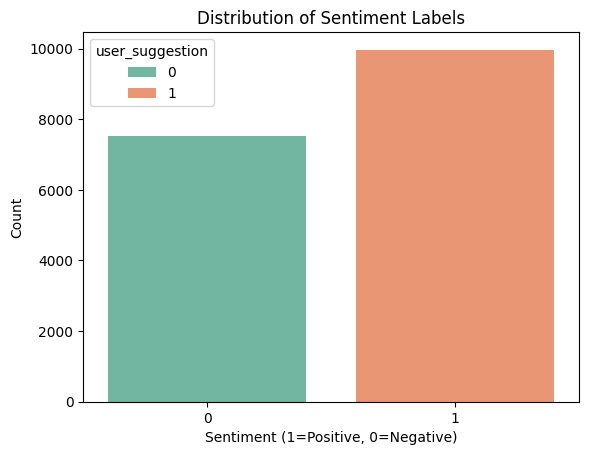

In [ ]:
sns.countplot(x='user_suggestion', data=d_steam, hue='user_suggestion', palette='Set2')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment (1=Positive, 0=Negative)')
plt.ylabel('Count')
plt.show()

From the distribution plot of the target variable (user_suggestion) we can see that there are more positive reviews than negative but it is not severely imbalanced and is acceptable, also,  models to be used further can handle this without any issue. Since the differene is not too much we do not need to perform class weight balancing or other oversampling techniques.

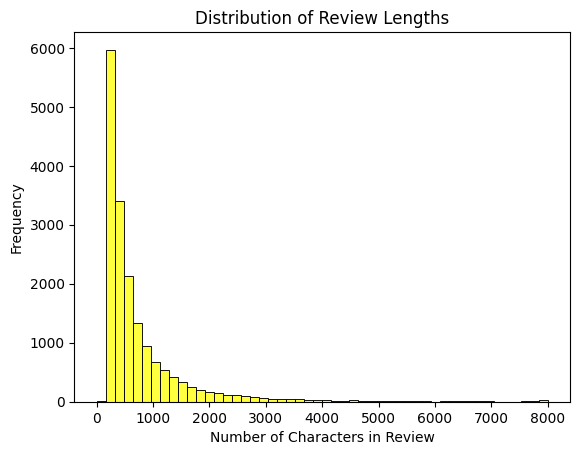

In [ ]:
d_steam['rev_len'] = d_steam['user_review'].astype(str).apply(len)
sns.histplot(d_steam['rev_len'], bins=50, color='yellow')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters in Review')
plt.ylabel('Frequency')
plt.show()

The above histogram shows us the distribution of review lengths indicating that long reviews (that have more character) can be seen rarely and short reviews are high in number. This learning is important for setting text length thresholds during data preprocessing especially for LSTM.

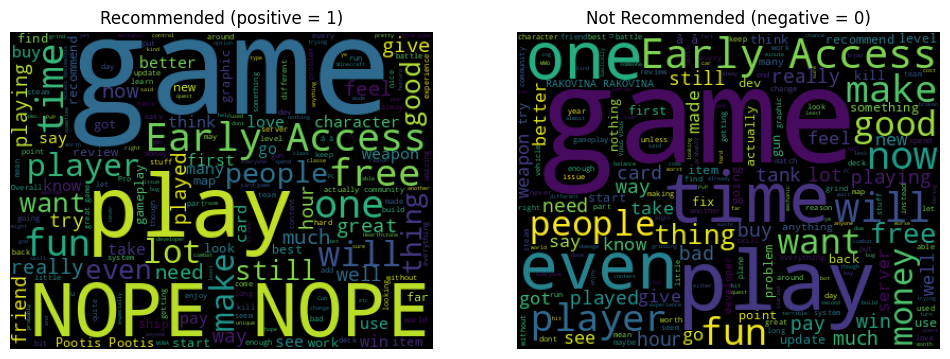

In [ ]:
ptxt = ' '.join(d_steam[d_steam['user_suggestion'] == 1]['user_review'])
ntxt = ' '.join(d_steam[d_steam['user_suggestion'] == 0]['user_review'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=399, height=299, background_color='black').generate(ptxt))
plt.title('Recommended (positive = 1)')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=399, height=299, background_color='black').generate(ntxt))
plt.title('Not Recommended (negative = 0)')
plt.axis('off')
plt.show()

Using the word cloud EDA tool we can understand the common words used in both positive and negative reviews. Even though it is not mandatory, using it helps for qualitative understanding before building models and to visually inspect whether they differ in word usage.

# Data Cleaning

In [ ]:
w_halt = set(stopwords.words('english'))
lemmat = WordNetLemmatizer()

def t_cln(text):
    tex = str(text).lower()
    tex = BeautifulSoup(tex, "html.parser").get_text()
    tex = re.sub(r'\d+', '', tex)
    tex = tex.translate(str.maketrans('', '', string.punctuation))
    tex = re.sub(r'\s+', ' ', tex).strip()
    tok = word_tokenize(tex)
    tok = [lemmat.lemmatize(word) for word in tok if word not in w_halt]
    return ' '.join(tok)

d_steam['cleaned_review'] = d_steam['user_review'].astype(str).apply(t_cln)
d_steam.tail(2)

,review_id,title,year,user_review,user_suggestion,rev_len,cleaned_review
17492,25538,EverQuest II,NaN,cool game. THe only thing that REALLY PISSES M...,1,264,cool game thing really piss ridable transport ...
17493,25539,EverQuest II,NaN,"this game since I was a little kid, always hav...",1,259,game since little kid always since still remem...


This step is required to prepare the reviews for analysis. In this, we have cleaned the text by removing HTML tags, punctuation, stopwords etc which is needed to reduce the noise to make sure the model performs efficiently.

In [ ]:
d_steam['review_typ'] = d_steam['user_suggestion'].map({1: 'recommended', 0: 'not_recommended'})
d_steam['review_cd'] = d_steam['review_typ'].map({'recommended': 1, 'not_recommended': 0})
d_steam[['cleaned_review', 'review_typ', 'review_cd']].tail(2)

,cleaned_review,review_typ,review_cd
17492,cool game thing really piss ridable transport ...,recommended,1
17493,game since little kid always since still remem...,recommended,1


Here we are converting the "user_suggestion" column into readable labels (recommended or not_recommended) and then encoded them back into numeric format making the data both human-readable and machine-compatible.

# Data Splitting

In [ ]:
cln_x = d_steam['cleaned_review']
cln_y = d_steam['review_cd']

train_forx, test_forx, train_fory, test_fory = train_test_split(
    cln_x, cln_y, test_size=0.2, stratify=cln_y, random_state=42
)

Aftre necessary cleaning of the dataset, we will split it with stratification to maintain the same proportion of sentiment classes in both sets. Splitting is being done before any preprocessing to prevent any sort of data leakage.

# Preprocessing and Feature Engineering
  * ## TF-IDF Vectorization


In [ ]:
vect = TfidfVectorizer(max_features=3000, stop_words='english')
train_forx_tfidf = vect.fit_transform(train_forx)
test_forx_tfidf = vect.transform(test_forx)

This step is important to convert raw text into sparse matrix of word importance scores which will be learnt by SVM

* ## Word2Vec Embeddings

In [ ]:
train_tok = train_forx.apply(lambda x: x.split())
test_tok = test_forx.apply(lambda x: x.split())

wrd_to_vec = Word2Vec(sentences=train_tok, vector_size=100, window=5, min_count=2, workers=4, epochs=30)

def avg_vec(tok):
    val_tok = [word for word in tok if word in wrd_to_vec.wv]
    return np.mean(wrd_to_vec.wv[val_tok], axis=0) if val_tok else np.zeros(100)



In [ ]:
train_forx_w2v = np.vstack(train_tok.apply(avg_vec))
test_forx_w2v = np.vstack(test_tok.apply(avg_vec))

This step generates dense vectors stacked into NumPy arrays which will be used for the training of the model.

# Usnig models and algorithms for training

* ## TF-IDF + SVM

As we know, TF-IDF vectorization creates sparse matrix and SVM with a linear kernel handles high-dimensional spaces very well and knows how to generalize noisy data (as in human-written reviews) which makes it ideal for this dataset. Thus we will use TF-IDF + SVM for efficient performance

In [ ]:
tf_idf_model = SVC(
    kernel='linear',
    probability=True,
    class_weight='balanced',
    random_state=42
)

tf_idf_model.fit(train_forx_tfidf, train_fory)

y_pred_tfidf = tf_idf_model.predict(test_forx_tfidf)

* Visual Evaluation



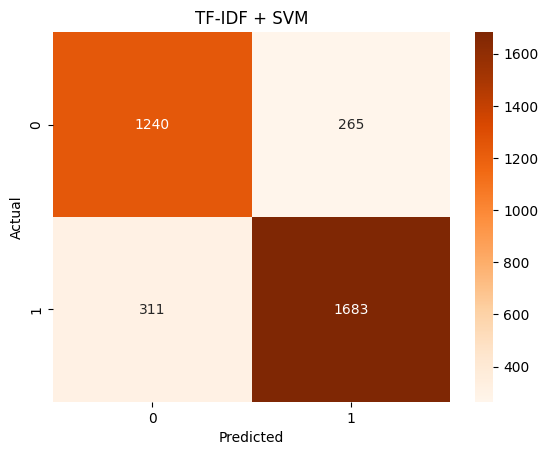

In [ ]:
tf_idf_confm = confusion_matrix(test_fory, y_pred_tfidf)
sns.heatmap(tf_idf_confm, annot=True, fmt='d', cmap='Oranges')
plt.title('TF-IDF + SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The confusion matrix shows

|              | Predicted 0 | Predicted 1 |
| ------------ | ----------- | ----------- |
| **Actual 0** | 1240        | 265         |
| **Actual 1** | 311         | 1683        |

Which tells us that the model is better at predicting class 1 and gives an overall good performance


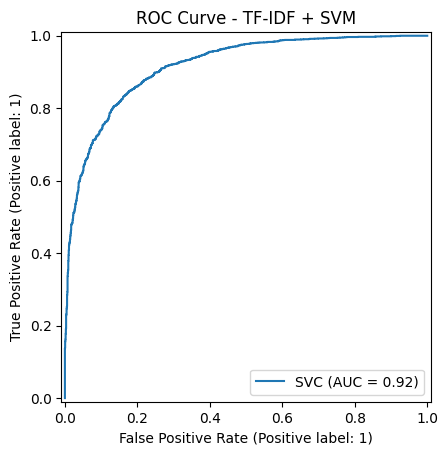

In [ ]:
RocCurveDisplay.from_estimator(tf_idf_model, test_forx_tfidf, test_fory)
plt.title('ROC Curve - TF-IDF + SVM')
plt.show()

The ROC Curve and AUC shows the tradeoff between the true positive rate and false positive rate and this shows how well the model is able to distinguish between the two classes. AUC = 0.92 which is closer to 1 means its really good and has high discriminatory power. Thus, SVC's high effectiveness is shown. However, logistic regression could also be a good candidate for text classification, so we will use that for comparison too.

* ## TF-IDF + Logistic regression

In [ ]:
logreg_tfidf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_tfidf.fit(train_forx_tfidf, train_fory)

y_pred_log_tfidf = logreg_tfidf.predict(test_forx_tfidf)

TF-IDF + Logistic Regression:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1505
           1       0.86      0.84      0.85      1994

    accuracy                           0.83      3499
   macro avg       0.83      0.83      0.83      3499
weighted avg       0.84      0.83      0.83      3499



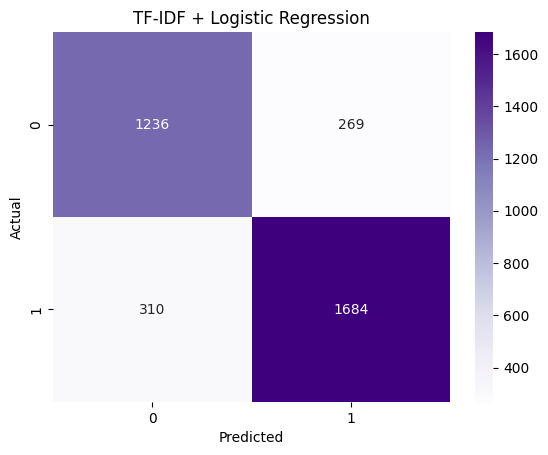

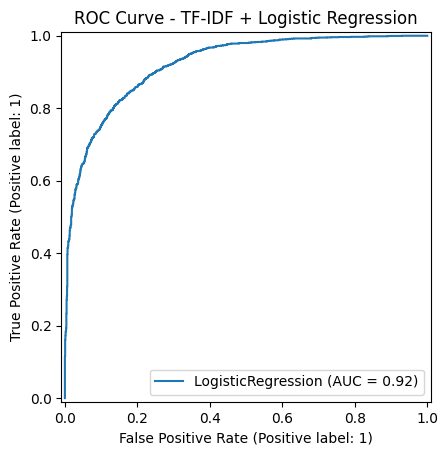

In [ ]:
print("TF-IDF + Logistic Regression:")
print(classification_report(test_fory, y_pred_log_tfidf))

conf_tfidf = confusion_matrix(test_fory, y_pred_log_tfidf)
sns.heatmap(conf_tfidf, annot=True, fmt='d', cmap='Purples')
plt.title('TF-IDF + Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

RocCurveDisplay.from_estimator(logreg_tfidf, test_forx_tfidf, test_fory)
plt.title("ROC Curve - TF-IDF + Logistic Regression")
plt.show()

The confusion matrix shows

|              | Predicted 0 | Predicted 1 |
| ------------ | ----------- | ----------- |
| **Actual 0** | 1236        | 269         |
| **Actual 1** | 310         | 1684        |

Which tells us that the model is better at predicting class 1 and gives an overall good performance

AUC = 0.92 which is closer to 1 means its really good and has high discriminatory power. Thus SVM and LR showed the same.

* ## Word2Vec + SVM

To make it a fair comparison it is important that we use the same algorithm in both tfidf and w2v so we can properly analyze which model performs better.

In [ ]:
svm_model_w2v = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)

svm_model_w2v.fit(train_forx_w2v, train_fory)

yprd_svm_w2v = svm_model_w2v.predict(test_forx_w2v)
yproba_svm_w2v = svm_model_w2v.predict_proba(test_forx_w2v)[:, 1]

Classification Report: Word2Vec + SVM

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1505
           1       0.87      0.82      0.85      1994

    accuracy                           0.83      3499
   macro avg       0.83      0.83      0.83      3499
weighted avg       0.83      0.83      0.83      3499



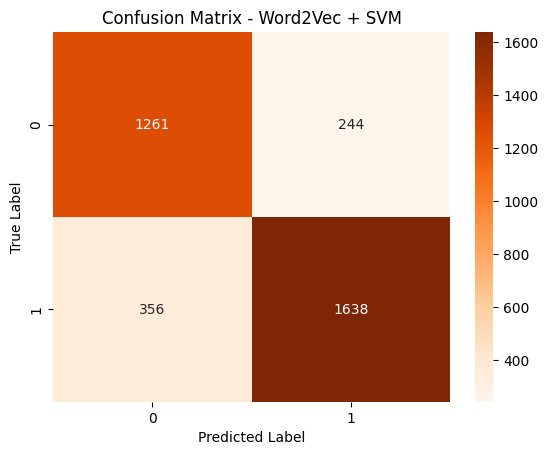

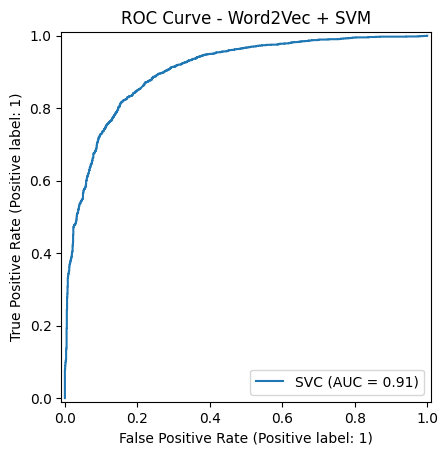

AUC Score: 0.9053


In [ ]:
print("Classification Report: Word2Vec + SVM\n")
print(classification_report(test_fory, yprd_svm_w2v))

conf_matrix_svm_w2v = confusion_matrix(test_fory, yprd_svm_w2v)
sns.heatmap(conf_matrix_svm_w2v, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - Word2Vec + SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

RocCurveDisplay.from_estimator(svm_model_w2v, test_forx_w2v, test_fory)
plt.title("ROC Curve - Word2Vec + SVM")
plt.show()

auc_svm_w2v = roc_auc_score(test_fory, yproba_svm_w2v)
print(f"AUC Score: {auc_svm_w2v:.4f}")

The confusion matrix shows

|              | Predicted 0 | Predicted 1 |
| ------------ | ----------- | ----------- |
| **Actual 0** | 1261        | 244         |
| **Actual 1** | 356         | 1638        |

AUC = 0.91 which is closer to 1 means its really good and has high discriminatory power.

* ## Word2Vec + Logistic Regresion

In [ ]:
logreg_w2v = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_w2v.fit(train_forx_w2v, train_fory)

y_pred_log_w2v = logreg_w2v.predict(test_forx_w2v)

Classification Report for Word2Vec + Logistic Regression:

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      1505
           1       0.87      0.82      0.84      1994

    accuracy                           0.83      3499
   macro avg       0.82      0.83      0.82      3499
weighted avg       0.83      0.83      0.83      3499



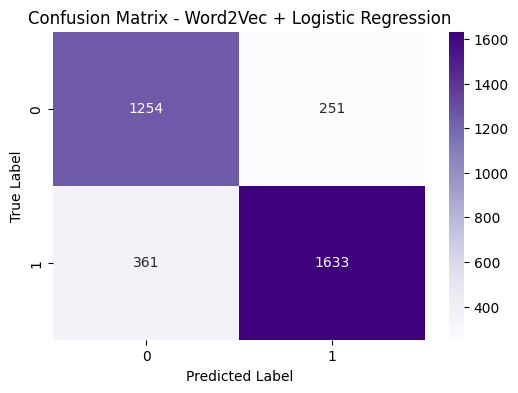

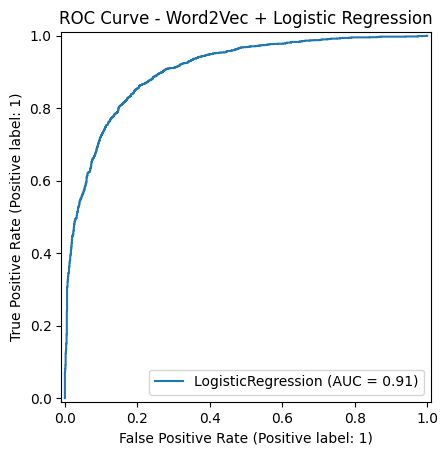

AUC Score: 0.9057


In [ ]:
y_pred_log_w2v = logreg_w2v.predict(test_forx_w2v)
y_proba_log_w2v = logreg_w2v.predict_proba(test_forx_w2v)[:, 1]

print("Classification Report for Word2Vec + Logistic Regression:\n")
print(classification_report(test_fory, y_pred_log_w2v))

plt.figure(figsize=(6, 4))
conf_matrix_w2v = confusion_matrix(test_fory, y_pred_log_w2v)
sns.heatmap(conf_matrix_w2v, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Word2Vec + Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

RocCurveDisplay.from_estimator(logreg_w2v, test_forx_w2v, test_fory)
plt.title("ROC Curve - Word2Vec + Logistic Regression")
plt.show()

auc_w2v = roc_auc_score(test_fory, y_proba_log_w2v)
print(f"AUC Score: {auc_w2v:.4f}")

The confusion matrix shows

|              | Predicted 0 | Predicted 1 |
| ------------ | ----------- | ----------- |
| **Actual 0** | 1254        | 251         |
| **Actual 1** | 361         | 1633        |

AUC = 0.91 which is closer to 1 means its really good and has high discriminatory power.

* ## LSTM (Bidirectional LSTM)


In [ ]:
vo_sze = 10000
lenmx = 100
embeddim = 100
trun_typ = 'post'
padtyp = 'post'
oov_tok = "<OOV>"

tokiz = Tokenizer(num_words=vo_sze, oov_token=oov_tok)
tokiz.fit_on_texts(train_forx)

train_forx_seq = tokiz.texts_to_sequences(train_forx)
test_forx_seq = tokiz.texts_to_sequences(test_forx)

train_forx_pad = pad_sequences(train_forx_seq, maxlen=100, padding='post', truncating='post')
test_forx_pad = pad_sequences(test_forx_seq, maxlen=100, padding='post', truncating='post')

In [ ]:
ls_tm_mod = Sequential([
    Embedding(vo_sze, 300),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

ls_tm_mod.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

This deep learning model was built using stacked Bidirectional LSTM layers to make sure both forward and backward context is captured from padded review sequences. The layers include dropout layers for regularization and the final dense layer has sigmoid activation for binary sentiment classification.

In [ ]:
erlystp = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = ls_tm_mod.fit(
    train_forx_pad, train_fory,
    epochs=15,
    validation_data=(test_forx_pad, test_fory),
    batch_size=64,
    callbacks=[erlystp],
    verbose=1
)

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 169s 742ms/step - accuracy: 0.6768 - loss: 0.5887 - val_accuracy: 0.8300 - val_loss: 0.3866
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 205s 756ms/step - accuracy: 0.8838 - loss: 0.2955 - val_accuracy: 0.8265 - val_loss: 0.4005
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 211s 799ms/step - accuracy: 0.9206 - loss: 0.2188 - val_accuracy: 0.8322 - val_loss: 0.4507
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 189s 742ms/step - accuracy: 0.9496 - loss: 0.1474 - val_accuracy: 0.8205 - val_loss: 0.5121


In [ ]:
loss, accuracy = ls_tm_mod.evaluate(test_forx_pad, test_fory)
print(f'✅ Test Accuracy: {accuracy:.4f}')

110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 118ms/step - accuracy: 0.8228 - loss: 0.3975
✅ Test Accuracy: 0.8300


To prevent overfitting, Early stopping has been used by keeping patience of 3 so it stops after 3 epochs of no improvement in valiadtion loss. The final evaluation shows us a test accuracy of 83% confiming that the model did well beyond training data.

110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1505
           1       0.87      0.83      0.85      1994

    accuracy                           0.83      3499
   macro avg       0.83      0.83      0.83      3499
weighted avg       0.83      0.83      0.83      3499



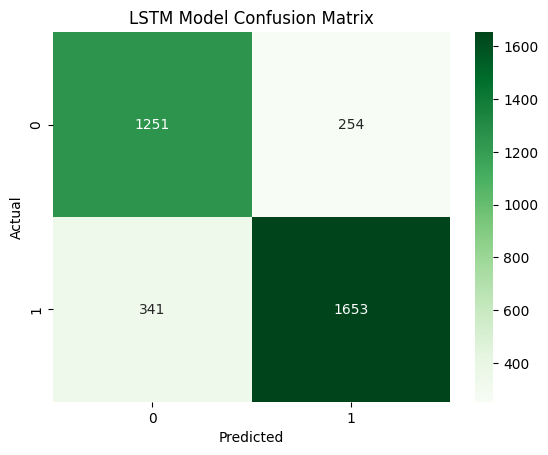

In [ ]:
yprdprb = ls_tm_mod.predict(test_forx_pad)
yprd = (yprdprb >= 0.5).astype(int)
yprd_ls_tm = yprd

print(classification_report(test_fory, yprd))

confm = confusion_matrix(test_fory, yprd)
sns.heatmap(confm, annot=True, fmt='d', cmap='Greens')
plt.title('LSTM Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The confusion matrix shows

|              | Predicted 0 | Predicted 1 |
| ------------ | ----------- | ----------- |
| **Actual 0** | 1251        | 254         |
| **Actual 1** | 341         | 1653        |



110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step


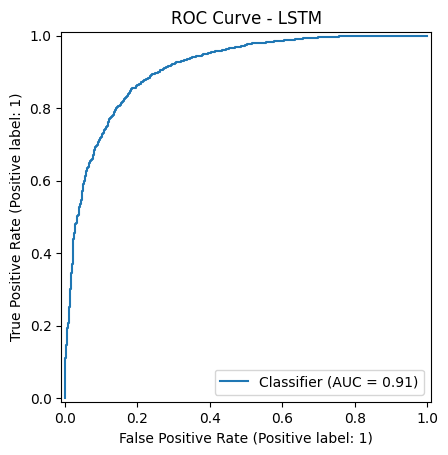

AUC Score: 0.9090970586177137


In [ ]:
y_probs_lstm = ls_tm_mod.predict(test_forx_pad).ravel()

RocCurveDisplay.from_predictions(test_fory, y_probs_lstm)
plt.title("ROC Curve - LSTM")
plt.show()

print("AUC Score:", roc_auc_score(test_fory, y_probs_lstm))


AUC = 0.91 which is closer to 1 means its really good and has high discriminatory power.

In [ ]:
compar_d_steam = pd.DataFrame({
    'Model': [
        'TF-IDF + SVM',
        'TF-IDF + Logistic Regression',
        'Word2Vec + SVM',
        'Word2Vec + Logistic Regression',
        'LSTM (Bidirectional LSTM)'
    ],
    'Accuracy': [
        accuracy_score(test_fory, y_pred_log_tfidf),
        accuracy_score(test_fory, y_pred_tfidf),
        accuracy_score(test_fory, y_pred_log_w2v),
        accuracy_score(test_fory, yprd_svm_w2v),
        accuracy_score(test_fory, yprd_ls_tm)
    ],
    'Precision': [
        precision_score(test_fory, y_pred_log_tfidf),
        precision_score(test_fory, y_pred_tfidf),
        precision_score(test_fory, y_pred_log_w2v),
        precision_score(test_fory, yprd_svm_w2v),
        precision_score(test_fory, yprd_ls_tm)
    ],
    'Recall': [
        recall_score(test_fory, y_pred_log_tfidf),
        recall_score(test_fory, y_pred_tfidf),
        recall_score(test_fory, y_pred_log_w2v),
        recall_score(test_fory, yprd_svm_w2v),
        recall_score(test_fory, yprd_ls_tm)
    ],
    'F1 Score': [
        f1_score(test_fory, y_pred_log_tfidf),
        f1_score(test_fory, y_pred_tfidf),
        f1_score(test_fory, y_pred_log_w2v),
        f1_score(test_fory, yprd_svm_w2v),
        f1_score(test_fory, yprd_ls_tm)
    ]
})


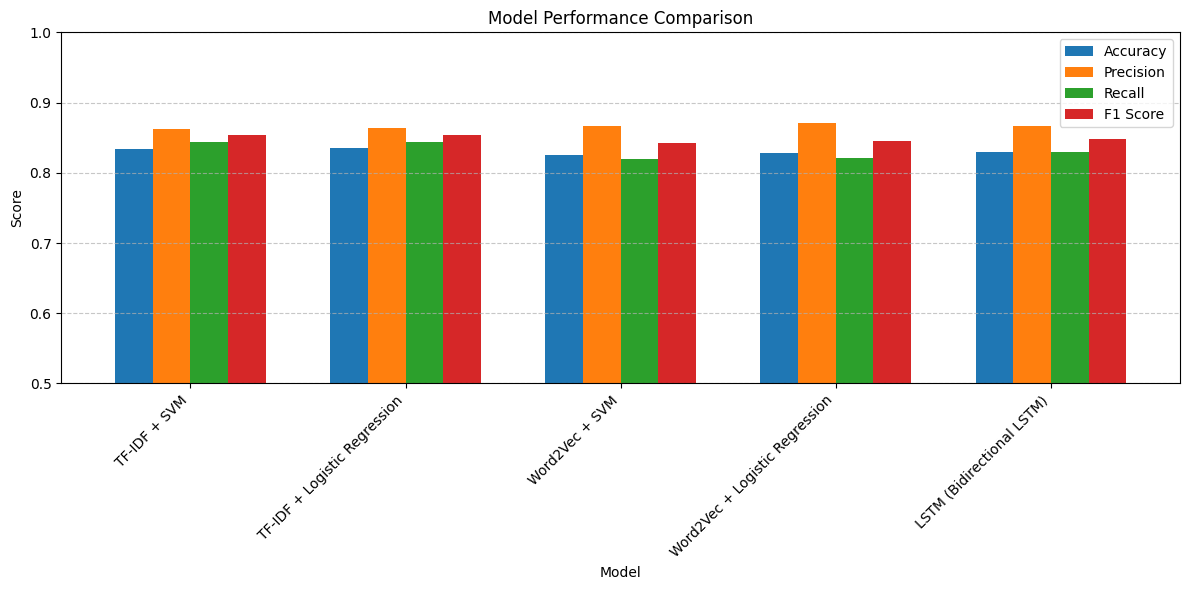

In [ ]:
compar_d_steam.plot(
    x='Model',
    y=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    kind='bar',
    figsize=(12, 6),
    width=0.7
)

plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Lets compare the models' performances in a simple table:

In [ ]:
compar_d_steam.round(3)

,Model,Accuracy,Precision,Recall,F1 Score
0,TF-IDF + SVM,0.835,0.862,0.845,0.853
1,TF-IDF + Logistic Regression,0.835,0.864,0.844,0.854
2,Word2Vec + SVM,0.825,0.867,0.819,0.842
3,Word2Vec + Logistic Regression,0.829,0.870,0.821,0.845
4,LSTM (Bidirectional LSTM),0.830,0.867,0.829,0.847


Thus we can see that all the models have performed well however TF-IDF + Logistic regression has performed slightly better.

# Conclusion

In this project we have explored sentiment analysis on Steam game reviews using three different modeling pipelines: tf-idf, word2vec and lstm

After seeing the final comparison table we can say that TF-IDF + Logistic regression performed better out of all other models with the highest F1 score of 0.854. Since all models are close in accuacy, F1 will help us differentiate here.

In conclusion, for tasks like Steam review classification, both classical and deep learning approaches are effective. The final model choice can depend on computational resources, interpretability requirements, and deployment feasibility. In future, models like BERT can be explored on larger datasets for deeper contextual understanding and comparison.
